# Predicting Uber taxi demand

## Introduction

This is our first application of the lecture contents. The goal is to predict Uber taxi demand in New York in February 2014. The content here is based on this article: https://medium.com/@dipti.galane/predicting-the-demand-of-number-of-uber-taxis-using-linear-regression-model-d31d4b6044f3 and the respective code.
Note that the preprocessing of this data has already been done and we are ready to use the data for our machine learning tasks.

## Methods used

For our prediction task, we use multiple different models. 

## Data Preprocessing Note

Before we dive into model building, let's briefly overview the preprocessing steps that were performed on our dataset:

- Removed unnecessary features such as 'store_and_fwd_flag', 'congestion_surcharge', 'airport_fee'.
- Duplicates were removed for cleaner data.
- Date and time columns were split for better analysis.
- Irregular data like trips with negative distances were excluded.
- Time of day was categorized into morning, afternoon, evening, and midnight.
- Holidays were identified and labeled.
- Data was aggregated based on several features for a comprehensive view.

This has been done by me before the lecture - if you want, you can also have a look at the preprocessing necessary.



In [2]:
# necessary imports
# if not installed already, you can install modules via:
# %pip install pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_percentage_error
import os

import fhnw_colourmap

#working directory
# working directory
wd = r"G:\My Drive\FHNW\2023-12-04_Präsentation\1_forecasting\DSMLPortfolioProject\source"
os.chdir(wd)
print("Current Working Directory: ", os.getcwd())


Current Working Directory:  G:\My Drive\FHNW\2023-12-04_Präsentation\1_forecasting\DSMLPortfolioProject\source


## Modules and working directory
First, we set the working directory and load the data.

## Exploratory Data Analysis (EDA)
The first step in a data science task is to do exploratory analysis. This means plotting and analysing the data to get a first overview and a rough understanding of the data.

We only use the January data here because we assume that we have no knowledge of the future (February) data.

### Nachfrage nach Taxis (Zeitreihe)

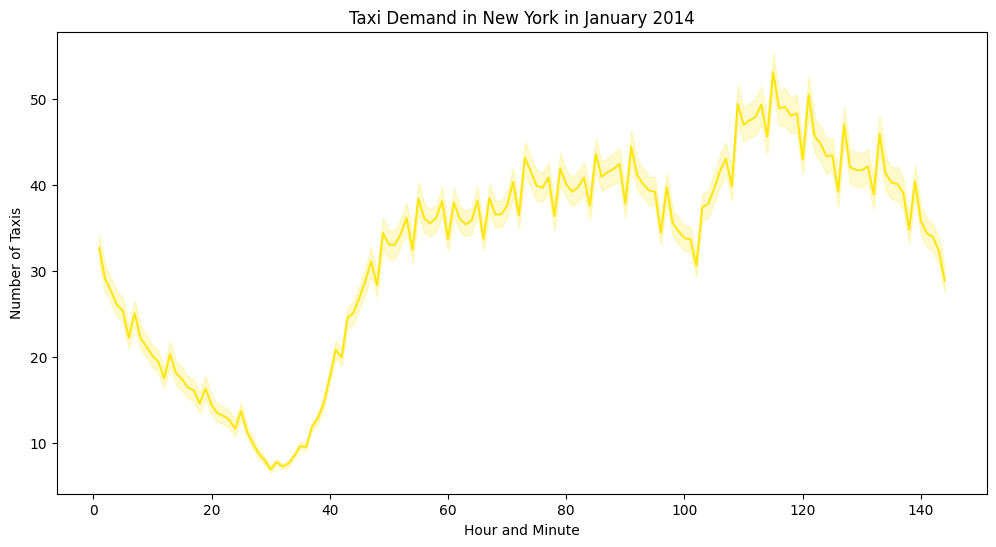

In [4]:
#Number of taxis based on the time of day

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_minute', y='number_of_taxis', data=jdata, color = fhnw_colourmap.fhnw_colour)
plt.title('Taxi Demand in New York in January 2014')
plt.xlabel('Hour and Minute')
plt.ylabel('Number of Taxis')
plt.show()

### Nachfrage an Feiertagen vs. an normalen Tagen

Als Nächstes veranschaulichen wir die Nachfrage an Feiertagen und an regulären Wochentagen. 

Feiertage sind Sonntage und Feiertage gemäss der US-Liste an offiziellen Feiertagen.

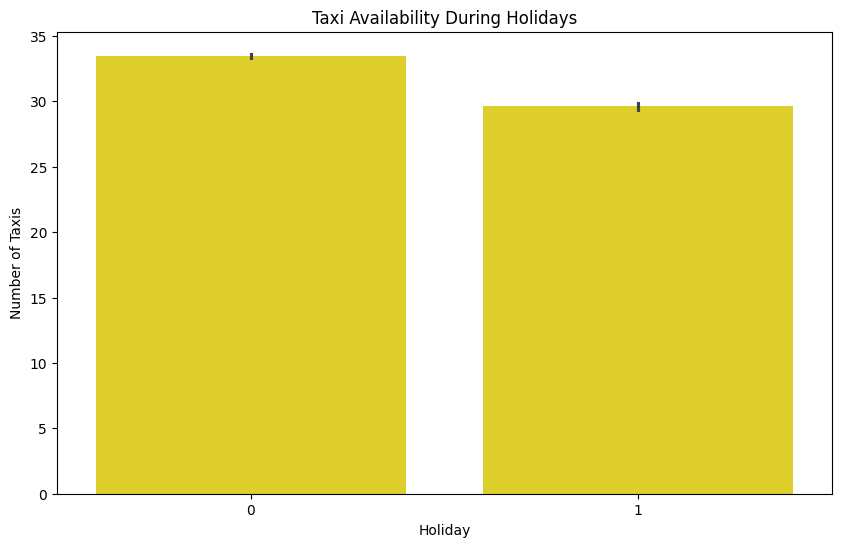

In [5]:

# 3. Bar Chart for Taxi Availability on Holidays
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='number_of_taxis', data=jdata, color= fhnw_colourmap.fhnw_colour)

plt.title('Taxi Availability During Holidays')
plt.xlabel('Holiday')
plt.ylabel('Number of Taxis')
plt.show()

### Nachfrage nach Taxis verteilt über Kategorien

Wir analysieren die Verteilung der Anzahl an Taxis gegeben der Tageszeit


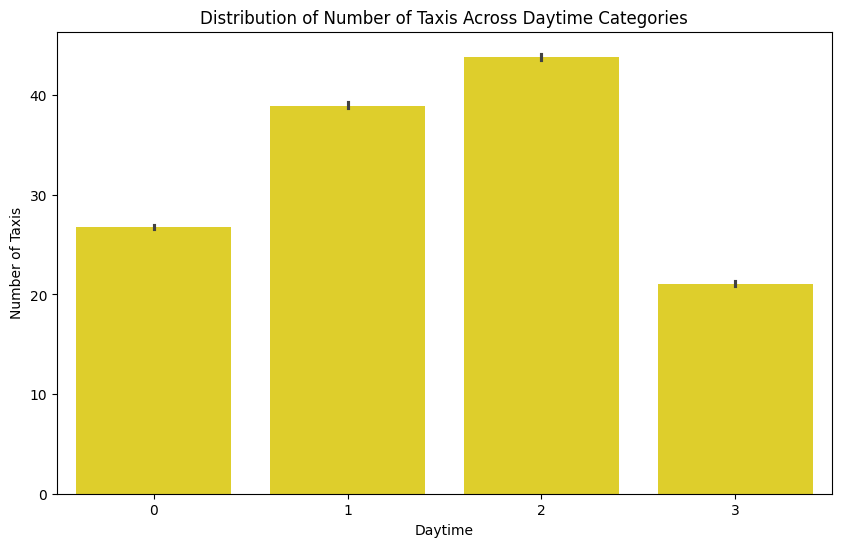

In [6]:
# 4. Box Plot for Daytime Categories
plt.figure(figsize=(10, 6))
sns.barplot(x='Daytime', y='number_of_taxis', data=jdata, color = fhnw_colourmap.fhnw_colour)
plt.title('Distribution of Number of Taxis Across Daytime Categories')
plt.xlabel('Daytime')
plt.ylabel('Number of Taxis')
plt.show()

# Predictive Forecasting mithilfe von Machine Learning

Wir haben die Schritte Preprocessing und EDA erfolgreich absolviert. Nun können wir versuchen, anhand der Daten Prognosen über die Zukunft zu gewinnen. Dieser Teil ist die sogenannte Predictive Data Analysis (PDA). 

Als Erstes müssen wir die Daten in eine Form bringen, welche für die ML-Algorithmen verwendbar ist. Wir unterteilen hierfür die Daten in Trainings- und Testdaten. Die Datensätze dienen unterschiedlichen Zwecken:

- Trainingsdaten werden verwendet, um das Modell zu schätzen. In diesem Fall sind das die Daten im Januar 2014.
- Testdaten werden verwendet, um zu überprüfen, wie gut das Modell funktioniert. In diesem Fall sind das die Daten im Februar 2014. 

Wir verwenden drei Variablen zur Prognose: Location ID, die Tageszeit "hour_minute", sowie den Monatsindikator "sdate".

In [31]:
#Splint into training and test data
# features = ["PULocationID",	"sdate",	"hour_minute",	"Daytime", "holiday"]
features = ['c1',
       'c2', 'c3', 'c4', 'c5']
X_train = jdata[features]
X_test = fdata[features]


# X_train = jdata.drop("number_of_taxis", axis = 1)
# X_test = fdata.drop("number_of_taxis", axis = 1)

## Min/Max Scaling

Weil die Variablen ggf. unterschiedlichen Skalen haben, müssen wir die Skalen vereinheitlichen. Dies erleichtert das Training des Modells. Hier skalieren wir auf die Dimension [-1,1].

In [32]:
#use a minmax scaler: Smallest value gets value -1, largest value gets +1.
minmax = MinMaxScaler(feature_range=(-1,1))

#fit the scaler on our data
minmax.fit(X_train)

#scale the data. Note: avoid data leak between training and testing, only fit on training data
xtrain = minmax.transform(X_train)
ytrain = jdata['number_of_taxis']
xtest = minmax.transform(X_test)
ytest = fdata['number_of_taxis']

## Lineare Regression

Wir trainieren als erstes ein simples lineares Modell. Wir gehen also davon aus, dass die Abhängigkeit zwischen unseren Variablen und der Nachfrage nach Taxis linear ist. 

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(xtrain, ytrain)

# Make predictions on the training and testing data
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculate the R^2 score for training and testing sets
r2_train = r2_score(ytrain, ytrain_pred)
r2_test = r2_score(ytest, ytest_pred)

# Print the R^2 scores
print(f"Training R^2 Score: {r2_train}")
print(f"Testing R^2 Score: {r2_test}")


Training R^2 Score: 0.9529676036547865
Testing R^2 Score: 0.9548922226561201


Wir sehen anhand des R^2-Koeffizienten, dass wir nur einen kleinen Teil des Problems erklären. Optimalerweise möchten wir R^2-Werte möglichst nahe an 1 erreichen. Wir können uns die Schätzung auch graphisch zeigen lassen:

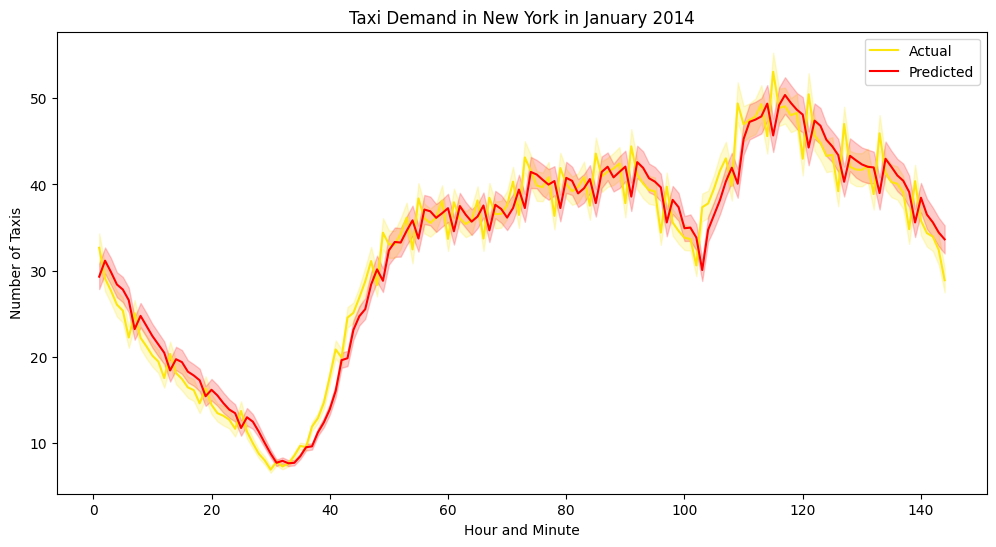

In [34]:
# Generating predictions for the January data (jdata)
jdata['predicted_taxis'] = model.predict(xtrain)

# Plotting the actual data
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_minute', y='number_of_taxis', data=jdata, color=fhnw_colourmap.fhnw_colour, label='Actual')

# Plotting the predicted data
sns.lineplot(x='hour_minute', y='predicted_taxis', data=jdata, color='red', label='Predicted')

plt.title('Taxi Demand in New York in January 2014')
plt.xlabel('Hour and Minute')
plt.ylabel('Number of Taxis')
plt.legend()
plt.show()



Wir sehen anhand unserer Schätzung also, dass wir eine etwas komplexere Schätzmethode benötigen. Hierfür könnten wir beispielsweise Polynomregression verwenden. 

## Polynomregression

Bei der Polynomregression können wir auch höhere Abhängigkeiten schätzen. 


In [11]:
from sklearn.preprocessing import PolynomialFeatures

# Choose the degree of your polynomial
degree = 2  # You can adjust this based on your requirement

# Initialize Polynomial Features
poly = PolynomialFeatures(degree)

# Transform the features to polynomial features
xtrain_poly = poly.fit_transform(xtrain)
xtest_poly = poly.transform(xtest)

# Initialize the Linear Regression model
poly_model = LinearRegression()

# Fit the model on the polynomial-transformed training data
poly_model.fit(xtrain_poly, ytrain)

# Make predictions on the polynomial-transformed training and testing data
ytrain_poly_pred = poly_model.predict(xtrain_poly)
ytest_poly_pred = poly_model.predict(xtest_poly)

# Calculate the R^2 score for training and testing sets
r2_train_poly = r2_score(ytrain, ytrain_poly_pred)
r2_test_poly = r2_score(ytest, ytest_poly_pred)

# Print the R^2 scores
print(f"Training R^2 Score with Polynomial Regression: {r2_train_poly}")
print(f"Testing R^2 Score with Polynomial Regression: {r2_test_poly}")



Training R^2 Score with Polynomial Regression: 0.9547319677497254
Testing R^2 Score with Polynomial Regression: 0.9558738148546427


Auch hier können wir uns anschauen, 